<a href="https://colab.research.google.com/github/LxMera/Convolutional-Neural-Network-for-the-classification-of-independent-components-of-rs-fMRI/blob/master/CNN_other_groups_(one_image).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [0]:
import os
import cv2
import sys
import glob
import random
import warnings
import numpy as np
import pandas as pd
import scipy.io as sio
import tensorflow as tf
from itertools import chain
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imread, imshow, imread_collection, concatenate_images

### Accesses to data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Directory

In [0]:
os.system('cp drive/My\ Drive/WhitePro/1000WhII_MB6.zip 1000WhII_MB6.zip')
os.system('cp drive/My\ Drive/WhitePro/460WhII_MB6.zip 460WhII_MB6.zip')
os.system('cp drive/My\ Drive/WhitePro/200WhII_Standard.zip 200WhII_Standard.zip')
os.system('cp drive/My\ Drive/WhitePro/200Standard.zip 200Standard.zip')
os.system('cp drive/My\ Drive/WhitePro/180Standard.zip 180Standard.zip')
os.system('cp drive/My\ Drive/WhitePro/145Standard.zip 145Standard.zip')

0

In [0]:
os.system('unzip 1000WhII_MB6.zip'),# os.system('rm -r 1000WhII_MB6.zip')
os.system('unzip 460WhII_MB6.zip'),# os.system('rm -r 460WhII_MB6.zip')
os.system('unzip 200WhII_Standard.zip'),# os.system('rm -r 200WhII_Standard.zip')
os.system('unzip 200Standard.zip'),# os.system('rm -r 200Standard.zip')
os.system('unzip 180Standard.zip'),# os.system('rm -r 180Standard.zip')
os.system('unzip 145Standard.zip'),# os.system('rm -r 145Standard.zip')

(0,)

In [0]:
GROUPS=np.sort(glob.glob('*.zip'))
print(GROUPS)

['1000WhII_MB6.zip' '145Standard.zip' '180Standard.zip' '200Standard.zip'
 '200WhII_Standard.zip' '460WhII_MB6.zip']


In [0]:
grp=1
GROUPS[grp][:]

'145Standard.zip'

In [0]:
FOLD=np.sort(glob.glob(GROUPS[grp][:-4]+'/*[!_.mat]'))
DATA=glob.glob(GROUPS[grp][:-4]+'/*.mat')

print(FOLD)
print(DATA[-1])

['145Standard/AXI' '145Standard/BLU' '145Standard/COM' '145Standard/C_AXI'
 '145Standard/C_BLU' '145Standard/C_COM' '145Standard/C_PCA'
 '145Standard/PCA']
145Standard/Time.mat


In [0]:
label=sio.loadmat(GROUPS[grp][:-4]+'/Labels.mat')['labels'][0]
order=sio.loadmat(GROUPS[grp][:-4]+'/Order.mat')['order']
timeS=sio.loadmat(GROUPS[grp][:-4]+'/Time.mat')['series']

print('Labels per component     \t', np.shape(label))
print('Order of images          \t', np.shape(order))
print('Points time per component\t', np.shape(timeS))

Labels per component     	 (1678,)
Order of images          	 (1678,)
Points time per component	 (145, 1678)


### Images parameters

In [0]:
print(GROUPS[grp][:-4])
os.system('mkdir drive/My\ Drive/AnexosCNN2/ResultadTX'+str(grp))
os.system('mkdir drive/My\ Drive/AnexosCNN2/ResultadTX'+str(grp)+'/MAT')
os.system('mkdir drive/My\ Drive/AnexosCNN2/ResultadTX'+str(grp)+'/MODELS')
os.system('mkdir drive/My\ Drive/AnexosCNN2/ResultadTX'+str(grp)+'/TEST')

145Standard


256

In [0]:
form=np.array([[73,	92,	82], [41,	49,	34], [51,	63,	34], [49,	61,	48], [50,	61,	49], [72,	92,	70]])

In [0]:
DIR0='drive/My Drive/AnexosCNN2/ResultadoX'+str(grp)+'/'
slic=['/Saggital','/Coronal','/Axial']

#Original shape
#SAG=form[grp,0]
#COR=form[grp,1]
#AXI=form[grp,2]

SAG=57
COR=73
AXI=57

IMG_CHANNELS = 3
nb_classes=2
maxR=0.4
shap={'Axial': (SAG, COR, IMG_CHANNELS), 'Coronal': (SAG, AXI, IMG_CHANNELS), 'Saggital': (AXI, COR, IMG_CHANNELS)}
numFolder=1 #number of folder
print(FOLD[numFolder])

145Standard/BLU


### Training and test data

In [0]:
per=0.8
per=int(np.shape(label)[0]*0.8)

TEST_PATH=order[per:]
TRAIN_PATH=order[:per]

y_test =label[per:]
y_train=label[:per]

print('training labels ', y_train.shape)
print('test labels     ', y_test.shape)

print('training maps   ', TRAIN_PATH.shape)
print('test maps       ', TEST_PATH.shape)

training labels  (1342,)
test labels      (336,)
training maps    (1342,)
test maps        (336,)


In [0]:
def showSlices(ima1, ima2, ima3, sh=False):
  plt.figure(figsize=(20,5))
  plt.subplot(1,3,1)
  plt.imshow(ima1)
  plt.title('Saggital')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(ima2)
  plt.title('Coronal')
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(ima3)
  plt.title('Axial')
  plt.axis('off')

  if sh:
    print('Saggital shape ', np.shape(ima1))
    print('Coronal shape ', np.shape(ima2))
    print('Axial shape ', np.shape(ima3))

### Training images

In [0]:
def TrainingImages(ni):
  print(FOLD[ni])
  s_train = np.zeros((len(TRAIN_PATH), AXI, COR, 3), dtype=np.uint8)
  c_train = np.zeros((len(TRAIN_PATH), SAG, AXI, 3), dtype=np.uint8)
  a_train = np.zeros((len(TRAIN_PATH), SAG, COR, 3), dtype=np.uint8)

  cont=0
  loop=len(TRAIN_PATH)

  for n in range(loop):  
    namea=FOLD[ni]+slic[2]+'/'+TRAIN_PATH[n].strip()+'.png'
    namec=FOLD[ni]+slic[1]+'/'+TRAIN_PATH[n].strip()+'.png'
    names=FOLD[ni]+slic[0]+'/'+TRAIN_PATH[n].strip()+'.png'
    
    imaa=cv2.imread(namea)
    imac=cv2.imread(namec)
    imas=cv2.imread(names)

    sag=cv2.resize(imas, (AXI, COR), interpolation = cv2.INTER_AREA)
    cor=cv2.resize(imac, (AXI, SAG), interpolation = cv2.INTER_AREA)
    axi=cv2.resize(imaa, (COR, SAG), interpolation = cv2.INTER_AREA)

    s_train[n]=np.rot90(sag)
    c_train[n]=cor
    a_train[n]=axi

    cont=cont+1
    print('\rProcess ', round(cont*100/loop,2), '%...' , end ="")
  return s_train, c_train, a_train

### Sample images (training)

145Standard/BLU
Process  100.0 %...

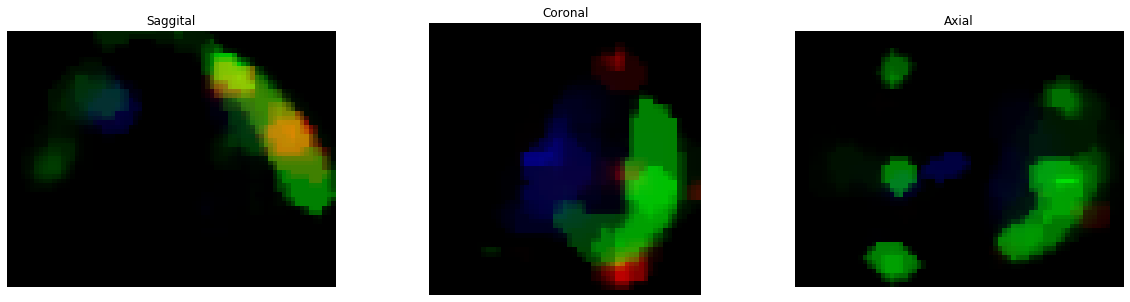

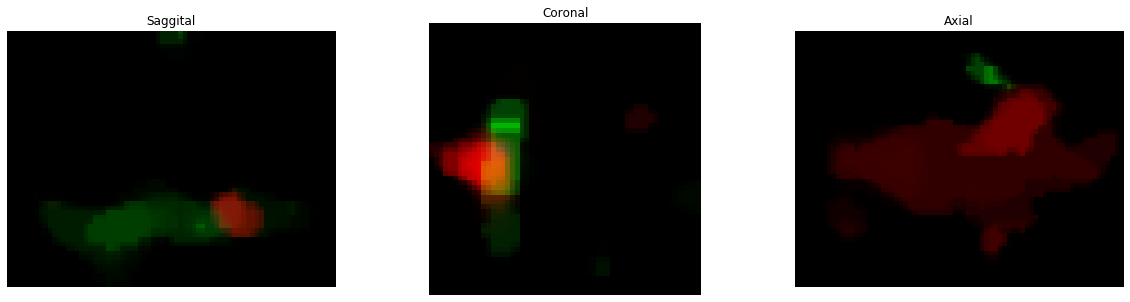

In [0]:
SCA_train=TrainingImages(numFolder)

signal=np.random.choice(np.where(y_train==1)[0])
noise=np.random.choice(np.where(y_train==0)[0])
showSlices(SCA_train[0][signal], SCA_train[1][signal], SCA_train[2][signal])
showSlices(SCA_train[0][noise], SCA_train[1][noise], SCA_train[2][noise])

### Test images

In [0]:
def testImages(ni): 
  print(FOLD[ni])
  s_test = np.zeros((len(TEST_PATH), AXI, COR, 3), dtype=np.uint8)
  c_test = np.zeros((len(TEST_PATH), SAG, AXI, 3), dtype=np.uint8)
  a_test = np.zeros((len(TEST_PATH), SAG, COR, 3), dtype=np.uint8)

  cont=0
  loop=len(TEST_PATH)

  for n in range(loop):  
    namea=FOLD[ni]+slic[2]+'/'+TEST_PATH[n].strip()+'.png'
    namec=FOLD[ni]+slic[1]+'/'+TEST_PATH[n].strip()+'.png'
    names=FOLD[ni]+slic[0]+'/'+TEST_PATH[n].strip()+'.png'
    
    imaa=cv2.imread(namea)
    imac=cv2.imread(namec)
    imas=cv2.imread(names)

    sag=cv2.resize(imas, (AXI, COR), interpolation = cv2.INTER_AREA)
    cor=cv2.resize(imac, (AXI, SAG), interpolation = cv2.INTER_AREA)
    axi=cv2.resize(imaa, (COR, SAG), interpolation = cv2.INTER_AREA)

    s_test[n]=np.rot90(sag)
    c_test[n]=cor
    a_test[n]=axi

    cont=cont+1
    print('\rProcess ', round(cont*100/loop,2), '%...' , end ="")
  return s_test, c_test, a_test

### sample images (test)

145Standard/BLU
Process  100.0 %...

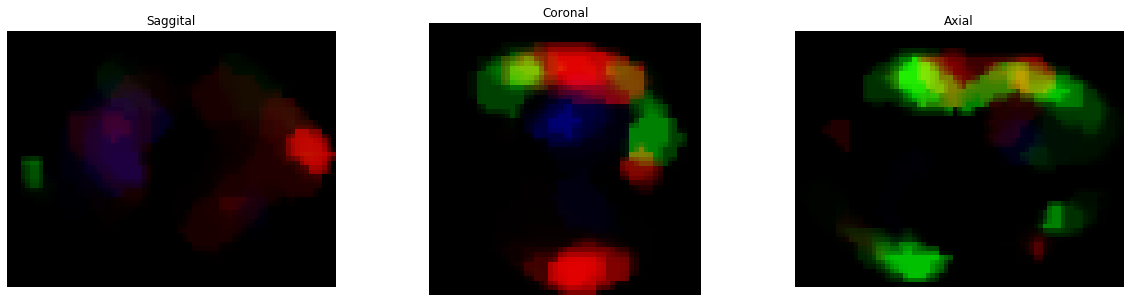

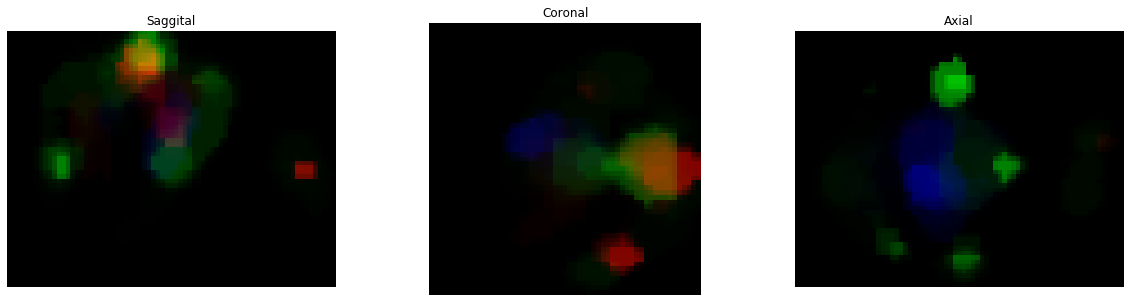

In [0]:
SCA_test=testImages(numFolder)

signal=np.random.choice(np.where(y_test==1)[0])
noise=np.random.choice(np.where(y_test==0)[0])
showSlices(SCA_test[0][signal], SCA_test[1][signal], SCA_test[2][signal])
showSlices(SCA_test[0][noise], SCA_test[1][noise], SCA_test[2][noise])

In [0]:
print(np.shape(SCA_train[0]))
print(np.shape(SCA_test[0]))

(1342, 57, 73, 3)
(336, 57, 73, 3)


### Model 1

In [0]:
def get_model_1(Slic):

    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(maxR) (c1)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = MaxPooling2D((2, 2)) (c1)    
    
    #Flatten layers
    c6 = Flatten()(c1)
        
    c6 = Dense(16, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)   

    c6 = Dense(8, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)  

    c6 = Dense(4, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)    
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

### Model with one layer

In [0]:
def get_Layer_1(Slic):
    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)    
    c1 = Dropout(maxR) (c1) 
    
    #Flatten layers
    c6 = Flatten()(c1)
        
    c6 = Dense(128, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)       
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

### Model with two layers

In [0]:
def get_Layer_2(Slic):
    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)    
    c1 = Dropout(maxR) (c1)

    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c2 = MaxPooling2D((2, 2)) (c2)    
    c2 = Dropout(maxR) (c2)
    
    #Flatten layers
    c6 = Flatten()(c2)
        
    c6 = Dense(128, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)       
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

### Model with three layers

In [0]:
def get_Layer_3(Slic):
    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)    
    c1 = Dropout(maxR) (c1)

    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c2 = MaxPooling2D((2, 2)) (c2)    
    c2 = Dropout(maxR) (c2)

    c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    c3 = MaxPooling2D((2, 2)) (c3)    
    c3 = Dropout(maxR) (c3)
    
    #Flatten layers
    c6 = Flatten()(c3)
        
    c6 = Dense(128, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)       
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

### Model with four layers

In [0]:
def get_Layer_4(Slic):
    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)    
    c1 = Dropout(maxR) (c1) 

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c2 = MaxPooling2D((2, 2)) (c2)    
    c2 = Dropout(maxR) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    c3 = MaxPooling2D((2, 2)) (c3)    
    c3 = Dropout(maxR) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    c4 = MaxPooling2D((2, 2)) (c4)    
    c4 = Dropout(maxR) (c4)
    
    #Flatten layers
    c6 = Flatten()(c4)

    c6 = Dense(512, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)
        
    c6 = Dense(128, activation='relu')(c6)
    c6 = Dropout(maxR)(c6)       
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

### Model LeNet

In [0]:
def get_LeNet(Slic):

    print(Slic+' model shape ', shap[Slic])
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input(shap[Slic])
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(20, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = MaxPooling2D((2, 2)) (c1)
    c1 = Dropout(maxR)(c1) 

    c2 = Conv2D(50, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    c2 = MaxPooling2D((2, 2)) (c2)
    c2 = Dropout(maxR)(c2) 

    c6 = Flatten()(c2)

    c6 = Dense(500, activation='relu')(c6)
    c6 = Dropout(maxR)(c6) 
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

### Model Tree SCA

In [0]:
def get_model_Tree_SCA():
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputsA = Input(shap['Axial'])
    sa = Lambda(lambda x: x / 255) (inputsA)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (sa)
    c1 = Dropout(maxR) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = MaxPooling2D((2, 2)) (c1)

    inputsC = Input(shap['Coronal'])
    sc = Lambda(lambda x: x / 255) (inputsC)
    c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (sc)
    c3 = Dropout(maxR) (c3)
    c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = MaxPooling2D((2, 2)) (c3) 

    inputsS = Input(shap['Saggital'])
    ss = Lambda(lambda x: x / 255) (inputsS)
    c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (ss)
    c5 = Dropout(maxR) (c5)
    c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = MaxPooling2D((2, 2)) (c5)

    #Flatten layers
    f2 = Flatten()(c1)
    f4 = Flatten()(c3)
    f6 = Flatten()(c5)

    c7 = concatenate([f2, f4, f6])     
        
    c7 = Dense(16, activation='relu')(c7)
    c7 = Dropout(maxR)(c7)   

    c7 = Dense(8, activation='relu')(c7)
    c7 = Dropout(maxR)(c7)  

    c7 = Dense(4, activation='relu')(c7)
    c7 = Dropout(maxR)(c7)    
       
    outputs = Dense(nb_classes, activation='softmax')(c7)

    model = Model(inputs=[inputsA, inputsC, inputsS], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    return model

# Training

In [0]:
from IPython.display import clear_output

In [0]:
DIR=DIR0+'MODELS/'
DIRM=DIR0+'MAT/'
DIRT=DIR0+'TEST/'
cr=len(GROUPS[grp][:-3])

for k in range(4):
  for i in range(8):
    SCA_train=TrainingImages(i)
    SCA_test=testImages(i) 
    for j in range(3):    
      ext=FOLD[i][cr:]+'-'+slic[j][1:]+'-'+str(k)+'.h5'

      name=DIR+'MODEL1-'+ext
      print(name)
      model0= get_model_1(slic[j][1:])
      earlystopper = EarlyStopping(patience=5, verbose=0)
      checkpointer = ModelCheckpoint(name, verbose=0, save_best_only=True)
      result = model0.fit(SCA_train[j], y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])
      sio.savemat(DIRM+name[45:-3]+'.mat', {'acc': result.history['acc'], 'val_acc': result.history['val_acc'],  'loss': result.history['loss'],  'val_loss': result.history['val_loss']})
      test_preds = model0.predict(SCA_test[j])
      test_pre=test_preds.argmax(axis=1)
      Accuracy = np.mean(test_pre == y_test)
      sio.savemat(DIRT+name[45:-3]+'.mat', {'Accuracy test': Accuracy,'vec_pred': test_preds})      
      del model0

      name=DIR+'LAYER1-'+ext
      print(name)
      model0= get_Layer_1(slic[j][1:])
      earlystopper = EarlyStopping(patience=5, verbose=0)
      checkpointer = ModelCheckpoint(name, verbose=0, save_best_only=True)
      result = model0.fit(SCA_train[j], y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])
      sio.savemat(DIRM+name[45:-3]+'.mat', {'acc': result.history['acc'], 'val_acc': result.history['val_acc'],  'loss': result.history['loss'],  'val_loss': result.history['val_loss']})
      test_preds = model0.predict(SCA_test[j])
      test_pre=test_preds.argmax(axis=1)
      Accuracy = np.mean(test_pre == y_test)
      sio.savemat(DIRT+name[45:-3]+'.mat', {'Accuracy test': Accuracy,'vec_pred': test_preds})
      del model0

      name=DIR+'LAYER2-'+ext
      print(name)
      model0= get_Layer_2(slic[j][1:])
      earlystopper = EarlyStopping(patience=5, verbose=0)
      checkpointer = ModelCheckpoint(name, verbose=0, save_best_only=True)
      result = model0.fit(SCA_train[j], y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])
      sio.savemat(DIRM+name[45:-3]+'.mat', {'acc': result.history['acc'], 'val_acc': result.history['val_acc'],  'loss': result.history['loss'],  'val_loss': result.history['val_loss']})
      test_preds = model0.predict(SCA_test[j])
      test_pre=test_preds.argmax(axis=1)
      Accuracy = np.mean(test_pre == y_test)
      sio.savemat(DIRT+name[45:-3]+'.mat', {'Accuracy test': Accuracy,'vec_pred': test_preds})
      del model0

      name=DIR+'LAYER3-'+ext
      print(name)
      model0= get_Layer_3(slic[j][1:])
      earlystopper = EarlyStopping(patience=5, verbose=0)
      checkpointer = ModelCheckpoint(name, verbose=0, save_best_only=True)
      result = model0.fit(SCA_train[j], y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])
      sio.savemat(DIRM+name[45:-3]+'.mat', {'acc': result.history['acc'], 'val_acc': result.history['val_acc'],  'loss': result.history['loss'],  'val_loss': result.history['val_loss']})
      test_preds = model0.predict(SCA_test[j])
      test_pre=test_preds.argmax(axis=1)
      Accuracy = np.mean(test_pre == y_test)
      sio.savemat(DIRT+name[45:-3]+'.mat', {'Accuracy test': Accuracy,'vec_pred': test_preds})
      del model0

      name=DIR+'LAYER4-'+ext
      print(name)
      model0= get_Layer_4(slic[j][1:])
      earlystopper = EarlyStopping(patience=5, verbose=0)
      checkpointer = ModelCheckpoint(name, verbose=0, save_best_only=True)
      result = model0.fit(SCA_train[j], y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])
      sio.savemat(DIRM+name[45:-3]+'.mat', {'acc': result.history['acc'], 'val_acc': result.history['val_acc'],  'loss': result.history['loss'],  'val_loss': result.history['val_loss']})
      test_preds = model0.predict(SCA_test[j])
      test_pre=test_preds.argmax(axis=1)
      Accuracy = np.mean(test_pre == y_test)
      sio.savemat(DIRT+name[45:-3]+'.mat', {'Accuracy test': Accuracy,'vec_pred': test_preds})
      del model0

      name=DIR+'LeNet-'+ext
      print(name)
      model0= get_LeNet(slic[j][1:])
      earlystopper = EarlyStopping(patience=5, verbose=0)
      checkpointer = ModelCheckpoint(name, verbose=0, save_best_only=True)
      result = model0.fit(SCA_train[j], y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])
      sio.savemat(DIRM+name[45:-3]+'.mat', {'acc': result.history['acc'], 'val_acc': result.history['val_acc'],  'loss': result.history['loss'],  'val_loss': result.history['val_loss']})
      test_preds = model0.predict(SCA_test[j])
      test_pre=test_preds.argmax(axis=1)
      Accuracy = np.mean(test_pre == y_test)
      sio.savemat(DIRT+name[45:-3]+'.mat', {'Accuracy test': Accuracy,'vec_pred': test_preds})
      del model0

      clear_output()